<a href="https://colab.research.google.com/github/romanescobar/Challenge-Telecom-X/blob/main/FlightOnTime_Modelado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

#Importación datos procesados
df = pd.read_csv('https://raw.githubusercontent.com/Sts87/FlightOnTime/refs/heads/feature/model-training/Airlines_processed.csv')
df.head()

,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,Time_day,Duration
0,CO,269,SFO,IAH,3,15,205,1,Early morning,Long
1,US,1558,PHX,CLT,3,15,222,1,Early morning,Long
2,AA,2400,LAX,DFW,3,20,165,1,Early morning,Medium
3,AA,2466,SFO,DFW,3,20,195,1,Early morning,Long
4,AS,108,ANC,SEA,3,30,202,0,Early morning,Long


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# --- FASE 4: ENTRENAMIENTO DEL MODELO ---
# 1. Definimos X (variables) e y (lo que queremos predecir)
X = df.drop(['Delay', 'Flight'], axis=1) # Quitamos 'Flight' por ser ruidoso
y = df['Delay']

In [ ]:
# 2. Dividimos los datos (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# 3. Entrenamos un Random Forest (Excelente para datos tabulares)
print("\nEntrenando el modelo... (esto puede tardar unos segundos)")

# Identificar columnas categóricas
categorical_cols = X_train.select_dtypes(include=['object']).columns

# Aplicar Label Encoding a las columnas categóricas en X_train y X_test
for col in categorical_cols:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    # Usa transform para X_test para asegurar consistencia con X_train
    X_test[col] = le.transform(X_test[col])

model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
model.fit(X_train, y_train)
print("¡Modelo entrenado con éxito!")


Entrenando el modelo... (esto puede tardar unos segundos)
¡Modelo entrenado con éxito!



--- Reporte de Clasificación ---
              precision    recall  f1-score   support

           0       0.64      0.86      0.73     59879
           1       0.69      0.39      0.50     47998

    accuracy                           0.65    107877
   macro avg       0.66      0.62      0.61    107877
weighted avg       0.66      0.65      0.63    107877



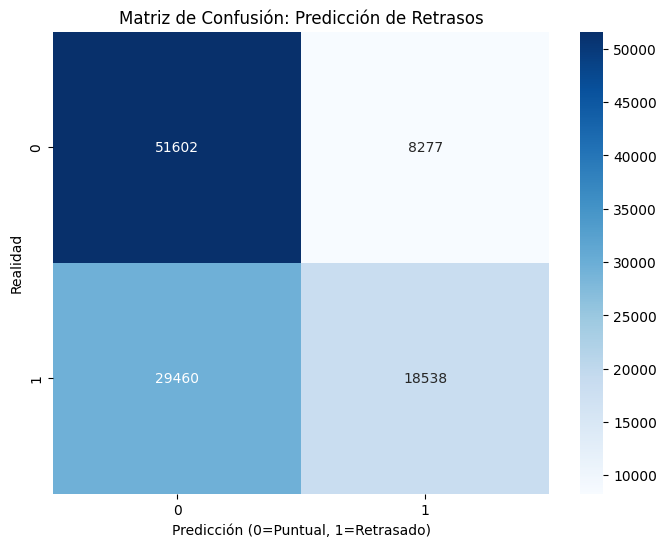


--- Importancia de las Variables ---
       feature  importance
0      Airline    0.458618
4         Time    0.241611
2    AirportTo    0.069251
5       Length    0.068105
6     Time_day    0.060806
1  AirportFrom    0.056545
3    DayOfWeek    0.027506
7     Duration    0.017557


In [ ]:
# --- FASE 5: EVALUACIÓN Y MÉTRICAS ---
# 1. Realizamos predicciones con el set de prueba
y_pred = model.predict(X_test)

# 2. Reporte de Clasificación
print("\n--- Reporte de Clasificación ---")
print(classification_report(y_test, y_pred))

# 3. Matriz de Confusión Visual
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión: Predicción de Retrasos')
plt.xlabel('Predicción (0=Puntual, 1=Retrasado)')
plt.ylabel('Realidad')
plt.show()

# 4. Importancia de las Variables (¿Qué influye más?)
importances = pd.DataFrame({'feature': X.columns, 'importance': model.feature_importances_})
importances = importances.sort_values('importance', ascending=False)
print("\n--- Importancia de las Variables ---")
print(importances)

In [ ]:
# =========================
# 5) ENTRENAMIENTO (MEJORADO)
# =========================
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# --- Config ---
TARGET = "Delay"  # ajusta si tu target se llama distinto

if TARGET not in df.columns:
    raise ValueError(f"No encuentro la columna target '{TARGET}' en df. Columnas: {list(df.columns)}")

# y debe ser binaria 0/1 (si no lo es, conviértela antes)
y = df[TARGET].astype(int)

# Opcional: quitar columnas que no deberían usarse como feature (ej. IDs o leakage)
DROP_COLS = [TARGET]
for col in ["Flight", "id"]:  # si existen, se eliminan
    if col in df.columns:
        DROP_COLS.append(col)

X = df.drop(columns=DROP_COLS).copy()

# Detectar categóricas y numéricas
categorical_features = X.select_dtypes(include=["object", "category"]).columns.tolist()
numeric_features = [c for c in X.columns if c not in categorical_features]

print("Features categóricas:", categorical_features)
print("Features numéricas  :", numeric_features)
print("Target balance (0/1):")
display(y.value_counts(normalize=True).rename("proporcion"))

# Preprocesamiento robusto
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features),
        ("num", StandardScaler(), numeric_features),
    ],
    remainder="drop"
)

# Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Modelos candidatos
models = {
    "LogisticRegression": LogisticRegression(max_iter=2000),
    "RandomForest": RandomForestClassifier(
        n_estimators=400,
        random_state=42,
        n_jobs=-1,
        class_weight="balanced"  # ayuda si hay desbalance
    ),
}

pipelines = {
    name: Pipeline(steps=[("preprocess", preprocess), ("model", model)])
    for name, model in models.items()
}

# Entrenar ambos
for name, pipe in pipelines.items():
    pipe.fit(X_train, y_train)
    print(f"✅ Entrenado: {name}")


In [7]:
# =========================
# 6) EVALUACIÓN (MEJORADA)
# =========================
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score
)
import matplotlib.pyplot as plt

def evaluate(name, pipe, X_test, y_test):
    y_pred = pipe.predict(X_test)

    # Probabilidad para endpoint /predict (si el modelo lo soporta)
    y_proba = None
    if hasattr(pipe, "predict_proba"):
        y_proba = pipe.predict_proba(X_test)[:, 1]

    metrics = {
        "model": name,
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall": recall_score(y_test, y_pred, zero_division=0),
        "f1": f1_score(y_test, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_test, y_proba) if y_proba is not None and len(np.unique(y_test)) == 2 else np.nan
    }

    print(f"\n===== {name} =====")
    for k in ["accuracy", "precision", "recall", "f1", "roc_auc"]:
        v = metrics[k]
        if isinstance(v, float) and np.isnan(v):
            print(f"{k.upper():>9}: N/A")
        else:
            print(f"{k.upper():>9}: {v:.4f}")

    print("\nClassification report:")
    print(classification_report(y_test, y_pred, zero_division=0))

    # Matriz de confusión (sin seaborn, solo matplotlib)
    cm = confusion_matrix(y_test, y_pred)
    fig = plt.figure()
    plt.imshow(cm)
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicho")
    plt.ylabel("Real")
    for (i, j), val in np.ndenumerate(cm):
        plt.text(j, i, int(val), ha="center", va="center")
    plt.show()

    return metrics

results = []
for name, pipe in pipelines.items():
    results.append(evaluate(name, pipe, X_test, y_test))

results_df = pd.DataFrame(results).sort_values(by="f1", ascending=False)
results_df


NameError: name 'pipelines' is not defined

In [8]:
# Elegimos el mejor por F1 (puedes cambiar el criterio a recall si prefieres priorizar detectar retrasos)
best_name = results_df.iloc[0]["model"]
best_model = pipelines[best_name]

print("🏆 Mejor modelo según F1:", best_name)

# Ejemplo de salida como la API necesita (previsión + probabilidad)
sample = X_test.sample(1, random_state=42)

pred_class = int(best_model.predict(sample)[0])
pred_prob  = float(best_model.predict_proba(sample)[0, 1])  # prob de clase "Retrasado" (=1)

response = {
    "prevision": "Retrasado" if pred_class == 1 else "Puntual",
    "probabilidad": pred_prob
}

print("Entrada (features):")
display(sample)

print("Salida tipo API:")
response


NameError: name 'results_df' is not defined